In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchinfo

# Imports

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
import torchvision.transforms as transforms
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import sys
import os
import pandas as pd
from collections import Counter
import seaborn as sn
from sklearn.metrics import confusion_matrix
import torchvision
import numpy as np
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm
import cv2
import math
import glob
from PIL import Image

import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, Dataset, random_split

# sys.path.insert(1, '../../util')
sys.path.insert(1, '/content/drive/MyDrive/VC/VCPI_Project/')
import vcpi_util

print(torch.__version__)

2.2.1+cu121


# Load data

In [ ]:
# Definindo o dispositivo para treinamento
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Este é para o Fernas, quando vierem utilizar comentem
# DATASET_PATH = 'data'
# TEST_SET_PATH = PATH_DATASET + '/test_images'
# TRAIN_SET_PATH = PATH_DATASET + 'train_images/GTSRB/Final_Training/Images'

DATASET_PATH = '/content/drive/MyDrive/VC/VCPI_Project/data'
TEST_SET_PATH = DATASET_PATH + '/test_images'
TRAIN_SET_PATH = DATASET_PATH + '/train_images/GTSRB/Final_Training/Images'

IMG_SIZE = 64
NUM_CHANNELS = 3 # Pictures are in RGB
BATCH_SIZE = 32
NUM_CLASSES = 43
CLASS_NAMES = os.listdir(f'{DATASET_PATH}/test_images')
EPOCHS = 20

cpu


# Converter imagens para .png

In [ ]:
def convert_images_to_png(dataset_path, output_base_path):
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.ppm'):
                try:
                    img = Image.open(os.path.join(root, file), mode='r')
                    base_name = os.path.basename(root)
                    class_folder = os.path.join(output_base_path, base_name)

                    os.makedirs(class_folder, exist_ok=True)

                    new_path = os.path.join(class_folder, file.replace('.ppm', '.png'))
                    img.save(new_path)

                except Exception as e:
                    print(f"Erro ao converter {file}: {e}")

PNG_TRAIN_PATH = '/content/drive/MyDrive/VC/VCPI_Project/train_png'
PNG_TEST_PATH = '/content/drive/MyDrive/VC/VCPI_Project/test_png'

convert_images_to_png(TRAIN_SET_PATH, PNG_TRAIN_PATH)
convert_images_to_png(TEST_SET_PATH, PNG_TEST_PATH)

In [ ]:
# Definição das transformações
transform = v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),  # Redimensionar as imagens
    v2.ToTensor(),        # Converter as imagens para tensores
])

# Carregamento dos conjuntos de treinamento e teste
train_set = torchvision.datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.MNIST(root=TEST_SET_PATH, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

images, targets = next(iter(train_loader))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
# For the training set
train_images, train_targets = next(iter(train_loader))
print("Training Set:")
print("Batch shape:", train_images.shape)
print(f"Targets: {train_targets}")
print("Training set samples:", len(train_loader.dataset))
print("Training set batches:", len(train_loader))

Training Set:
Batch shape: torch.Size([32, 3, 64, 64])
Targets: tensor([36, 25, 35,  5, 38,  3, 16,  9,  4, 14, 39, 17,  5, 12,  2,  8, 17, 18,
        13, 27, 11, 41, 13,  7, 21, 35,  7, 25,  3, 19, 35,  5])
Training set samples: 39226
Training set batches: 1226


In [ ]:
# For the test set
test_images, test_targets = next(iter(test_loader))
print("\nTest Set:")
print("Batch shape:", test_images.shape)
img_np = test_images.numpy()
print("Each image varies between", np.min(img_np), "and", np.max(img_np))
# Putting color channel last so that the image can be displayed
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Shape after channel transpose:", img_np.shape)
print("Test set samples:", len(test_loader.dataset))
print("Test set batches:", len(test_loader))


Test Set:
Batch shape: torch.Size([32, 1, 64, 64])
Each image varies between 0.0 and 1.0
Shape after channel transpose: (32, 64, 64, 1)
Test set samples: 10000
Test set batches: 313


# Marosca para as informações de cada imagem

In [ ]:
# # Para Fernas
# # csv_directory = 'data/train_images/GTSRB/Final_Training/Images'
# # Para Cat e Marta
# csv_directory = '/content/drive/MyDrive/VC/VCPI_Project/data/train_images/GTSRB/Final_Training/Images'

# image_info_by_class = {}

# # Iterar sobre os subdiretórios
# for subdir in os.listdir(csv_directory):
#     subdir_path = os.path.join(csv_directory, subdir)
#     if os.path.isdir(subdir_path):
#         # Iterar sobre os arquivos CSV em cada subdiretório
#         for filename in os.listdir(subdir_path):
#             if filename.endswith('.csv'):
#                 csv_path = os.path.join(subdir_path, filename)

#                 # Verificar se o arquivo CSV está vazio ou não
#                 if os.path.getsize(csv_path) == 0:
#                     print(f'O arquivo CSV {csv_path} está vazio.')
#                     continue

#                 # Abrir o arquivo CSV e ler as informações das imagens
#                 with open(csv_path, 'r') as csvfile:
#                     next(csvfile)  # Ignorar a primeira linha de cabeçalho
#                     for line in csvfile:
#                         # Dividir a linha usando o ponto e vírgula como delimitador
#                         row = line.strip().split(';')

#                         # Verificar se a linha contém informações suficientes
#                         if len(row) < 8:
#                             print(f'A linha do arquivo CSV {csv_path} não possui informações suficientes.')
#                             continue

#                         # Extrair informações da linha
#                         image_filename = row[0]  # Nome do arquivo de imagem
#                         class_id = row[7]  # ID da classe

#                         # Criar um dicionário para armazenar as informações da imagem
#                         image_info = {
#                             'Filename': row[0],
#                             'Width': row[1],
#                             'Height': row[2],
#                             'Roi.X1': row[3],
#                             'Roi.Y1': row[4],
#                             'Roi.X2': row[5],
#                             'Roi.Y2': row[6],
#                             'ClassId': row[7]
#                         }

#                         # Adicionar as informações da imagem ao dicionário correspondente à classe
#                         class_dict_key = f'GT-{class_id.zfill(5)}'
#                         if class_dict_key not in image_info_by_class:
#                             image_info_by_class[class_dict_key] = {}
#                         image_info_by_class[class_dict_key][image_filename] = image_info

In [ ]:
# # Exemplo de como acessar as informações de uma imagem específica de uma classe específica
# class_id = '00042'
# image_filename = '00000_00000.ppm'
# class_dict_key = f'GT-{class_id.zfill(5)}'
# image_info = image_info_by_class.get(class_dict_key, {}).get(image_filename)
# if image_info:
#     print(f'Informações da imagem {image_filename} da classe {class_id}: {image_info}')
# else:
#     print(f'As informações da imagem {image_filename} da classe {class_id} não foram encontradas.')

Informações da imagem 00000_00000.ppm da classe 00042: {'Filename': '00000_00000.ppm', 'Width': '27', 'Height': '28', 'Roi.X1': '5', 'Roi.Y1': '6', 'Roi.X2': '22', 'Roi.Y2': '23', 'ClassId': '42'}


# Display batch of images

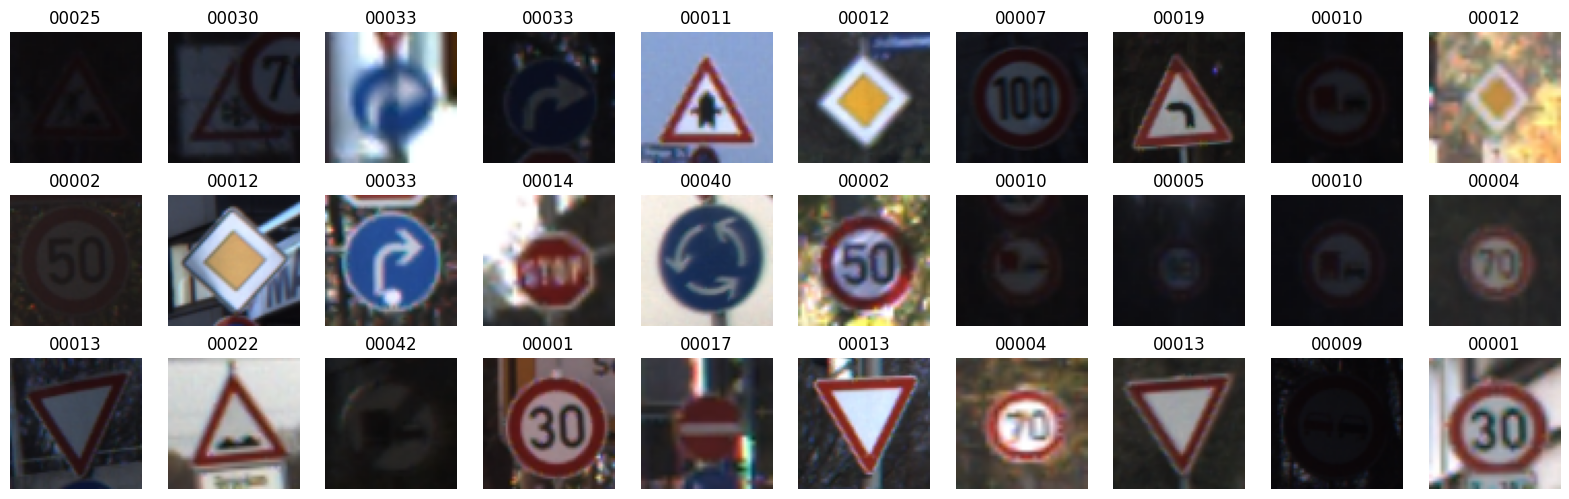

<Figure size 640x480 with 0 Axes>

In [ ]:
vcpi_util.show_images(3,10, train_images, train_targets, train_set.classes)

Counter({33: 3, 12: 3, 10: 3, 13: 3, 2: 2, 4: 2, 1: 2, 25: 1, 30: 1, 11: 1, 7: 1, 19: 1, 14: 1, 40: 1, 5: 1, 22: 1, 42: 1, 17: 1, 9: 1, 38: 1, 26: 1})


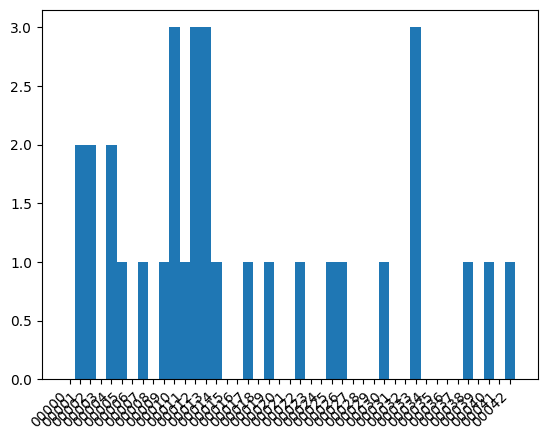

In [ ]:
vcpi_util.show_histogram(train_targets, train_set.classes)

In [ ]:
# # Função para mostrar o histograma de uma imagem
# def show_image_histogram(image, ax, image_name):
#     ax.hist(image.flatten(), bins=50, color='c')
#     ax.set_xlabel('Pixel Value')
#     ax.set_ylabel('Frequency')
#     ax.set_title(image_name)

In [ ]:
# Verificar normalização dos valores das imagens [0.0, 1.0]
print("Valor mínimo train_images:", torch.min(train_images))
print("Valor máximo train_images:", torch.max(train_images))
print()
print("Valor mínimo test_images:", torch.min(test_images))
print("Valor máximo test_images:", torch.max(test_images))

Valor mínimo train_images: tensor(0.)
Valor máximo train_images: tensor(1.)

Valor mínimo test_images: tensor(0.)
Valor máximo test_images: tensor(1.)


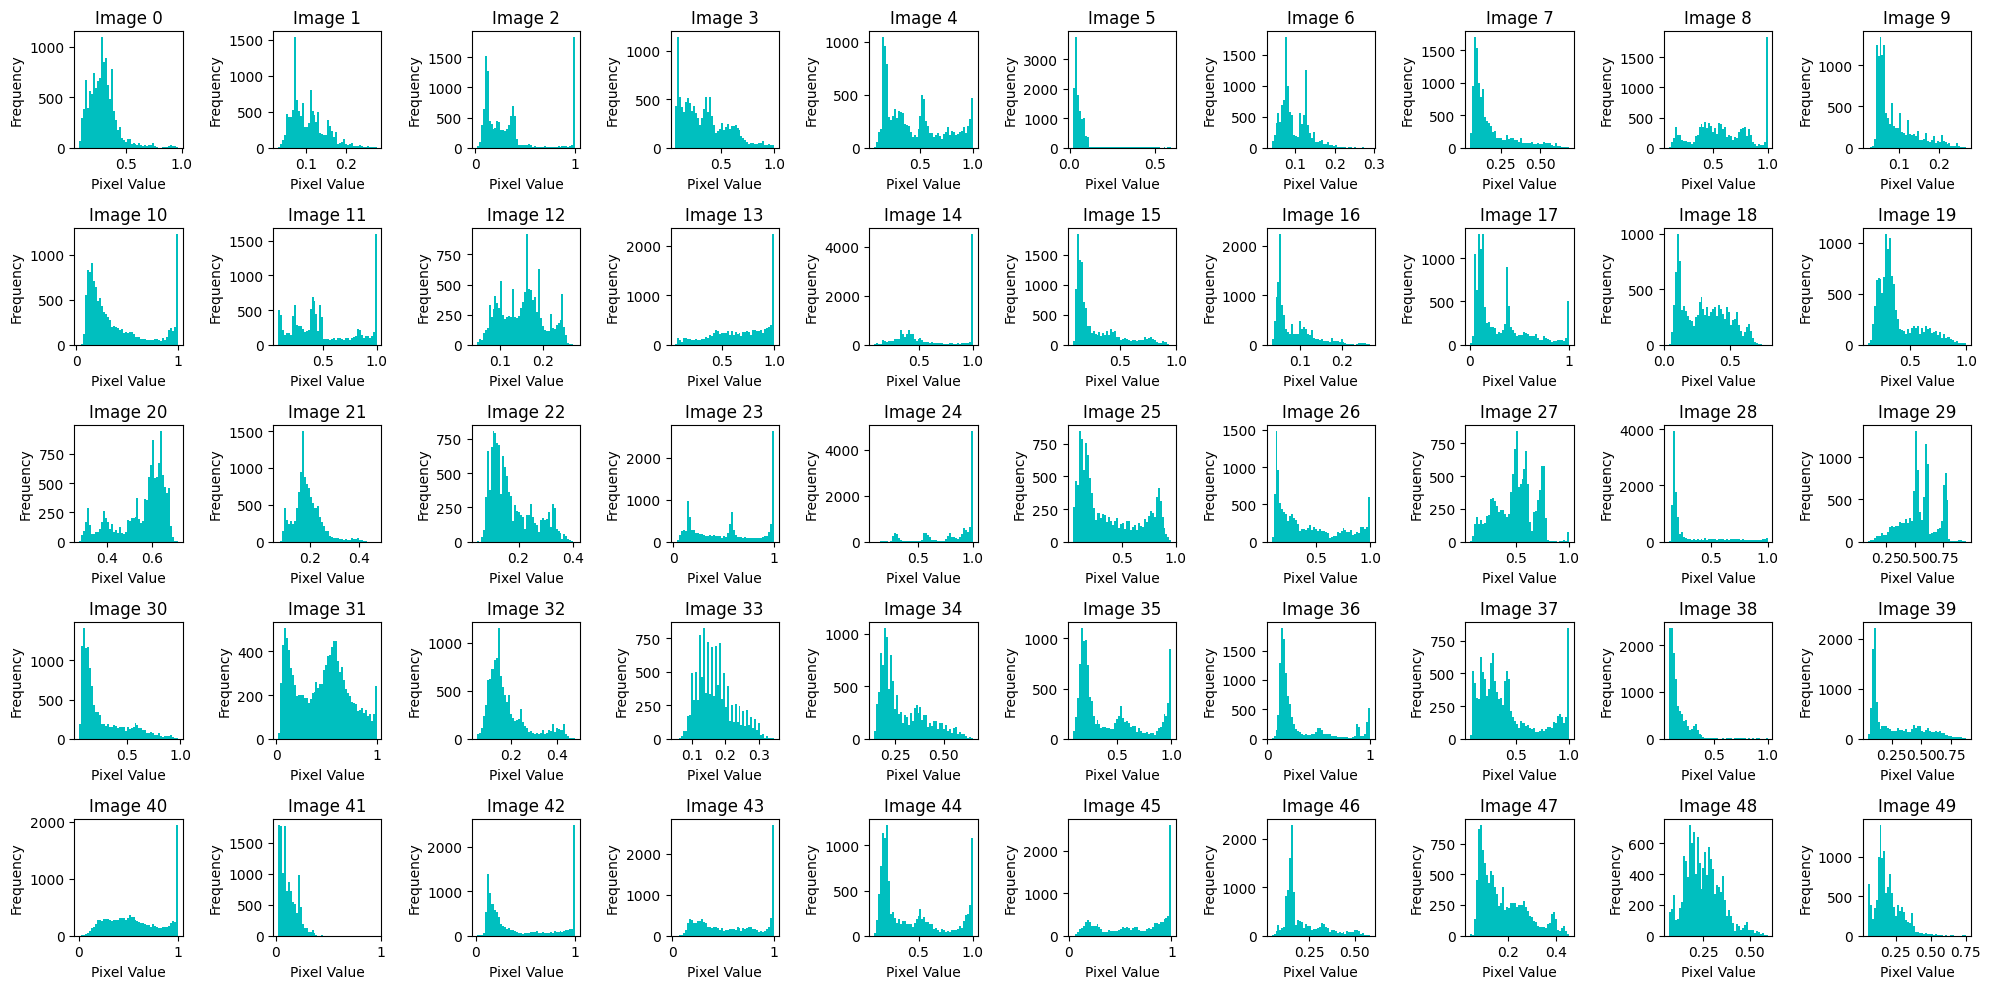

In [ ]:
# rows = 5
# cols = 10
# fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

# imagesHist, _ = train_images, train_targets
# for i, image in enumerate(imagesHist):
#     # Calcular as coordenadas da subplot
#     row = i // cols
#     col = i % cols
#     # Mostrar o histograma da imagem atual na subplot correspondente
#     show_image_histogram(image, axes[row, col], f'Image {i}')
#     # Parar o loop quando atingirmos o número total de subplots
#     if i == rows * cols - 1:
#         break

# plt.tight_layout()
# plt.show()

Equalização do histograma de frequências

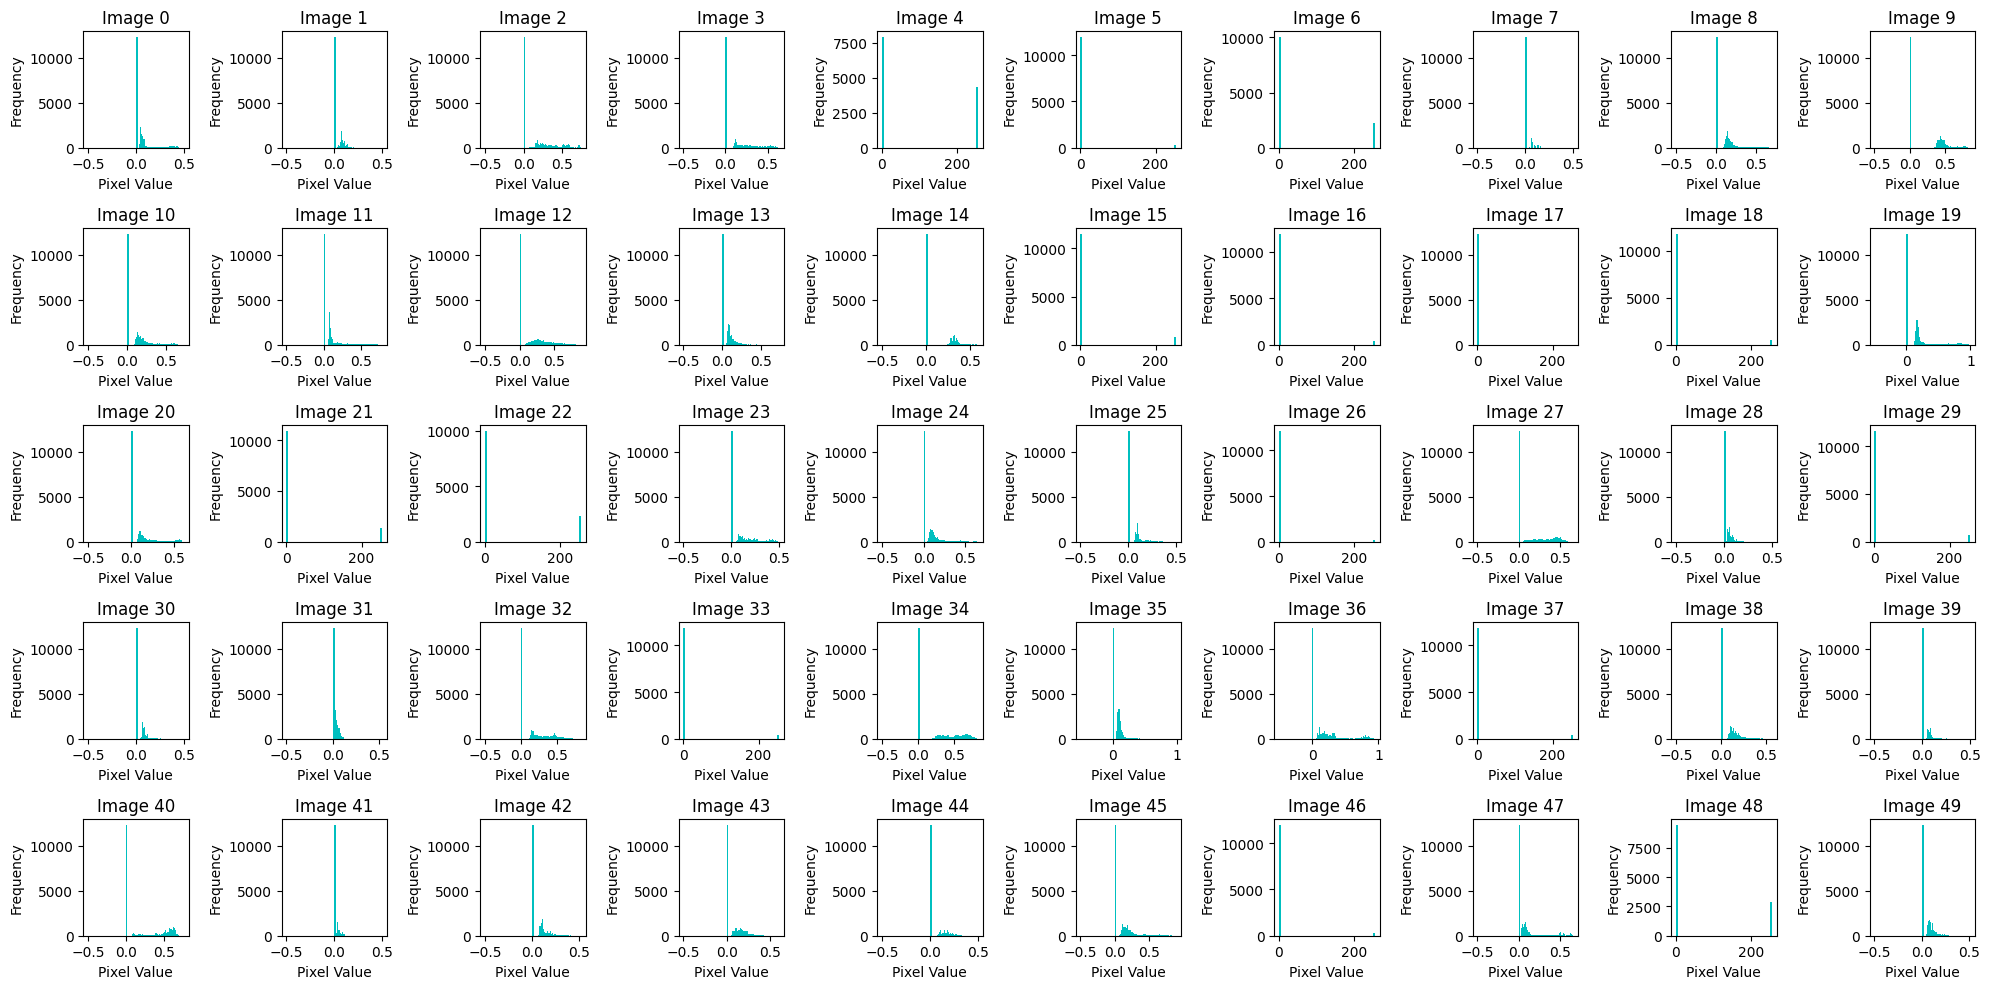

In [ ]:
# # Função para equalizar o histograma de uma imagem usando OpenCV
# def equalize_image_histogram_cv2(image):
#     # Assuming the image is a stack of grayscale images
#     # Convert each channel to a grayscale image and equalize its histogram
#     equalized_channels = []
#     for channel in range(image.shape[0]):
#         channel_image = image[channel, :, :]
#         channel_image = channel_image.astype('uint8')
#         equalized_channel = cv2.equalizeHist(channel_image)
#         equalized_channels.append(equalized_channel)

#     # Combine the equalized channels back into a single image
#     equalized_image = np.stack(equalized_channels, axis=0)
#     return equalized_image

# rows = 5
# cols = 10
# fig, axes = plt.subplots(rows, cols, figsize=(20, 10))

# imagesHist, _ = train_images, train_targets
# equalized_imgs = []
# for i, image in enumerate(imagesHist):
#     # Calcular as coordenadas da subplot
#     row = i // cols
#     col = i % cols
#     # Equalizar o histograma da imagem atual usando OpenCV
#     equalized_image_cv2 = equalize_image_histogram_cv2(image.numpy())
#     equalized_imgs.append(equalized_image_cv2)
#     # Mostrar o histograma da imagem equalizada na subplot correspondente
#     show_image_histogram(equalized_image_cv2, axes[row, col], f'Image {i}')
#     # Parar o loop quando atingirmos o número total de subplots
#     if i == rows * cols - 1:
#         break

# for i, image in enumerate(imagesHist):
#     # Calcular as coordenadas da subplot
#     row = i // cols
#     col = i % cols
#     if isinstance(image, torch.Tensor):
#         image_np = image.numpy()
#     else:
#         image_np = image
#     show_image_histogram(image_np, axes[row, col], f'Image {i}')
#     # Parar o loop quando atingirmos o número total de subplots
#     if i == rows * cols - 1:
#         break

# plt.tight_layout()
# plt.show()

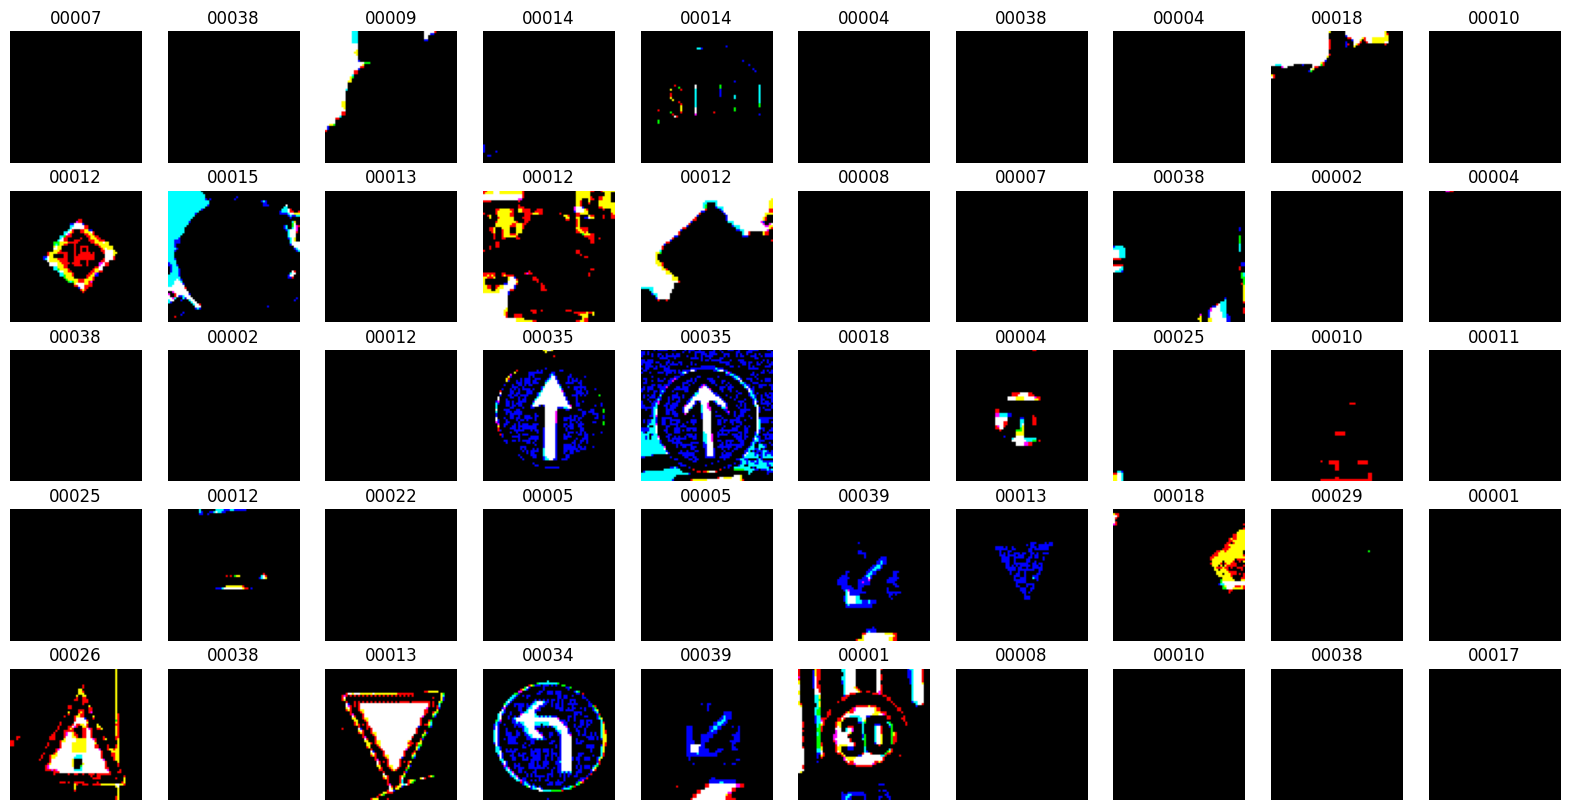

<Figure size 640x480 with 0 Axes>

In [ ]:
# equalized_imgs_numpy = np.stack(equalized_imgs)
# equalized_imgs_tensor = torch.tensor(equalized_imgs_numpy)

# vcpi_util.show_images(5,10, equalized_imgs_tensor, train_targets, train_set.classes)

Aplicação do filtro 'medianBlur' - remoção de ruído (Fixed by Fernas)

In [ ]:
# def show_images(rows, cols, images, targets, classes):
#     fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
#     for idx, img in enumerate(images):
#         # Convert to numpy and handle tensor condition
#         image = img.numpy() if torch.is_tensor(img) else img
#         image = np.transpose(image, (1, 2, 0))
#         image = (image * 255).astype(np.uint8)

#         # Converter RGB para Grayscale
#         if image.shape[2] == 3:
#             try:
#                 image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#             except Exception as e:
#                 print(f"Error converting to grayscale: {e}")
#                 continue

#         # Aplicar medianBlur para a GrayScale
#         image = cv2.medianBlur(image, 3)

#         # Display the image
#         ax = axes.ravel()[idx]
#         ax.set_title(classes[targets[idx]])
#         ax.imshow(image, cmap='gray')  # Ensure cmap is set to 'gray' for grayscale images
#         ax.axis('off')
#     fig.tight_layout()
#     plt.show()

# show_images(5, 10, train_images, train_loader, train_loader.classes)


AttributeError: 'DataLoader' object has no attribute 'classes'

Transformar as imagens em formato binário (threshold)

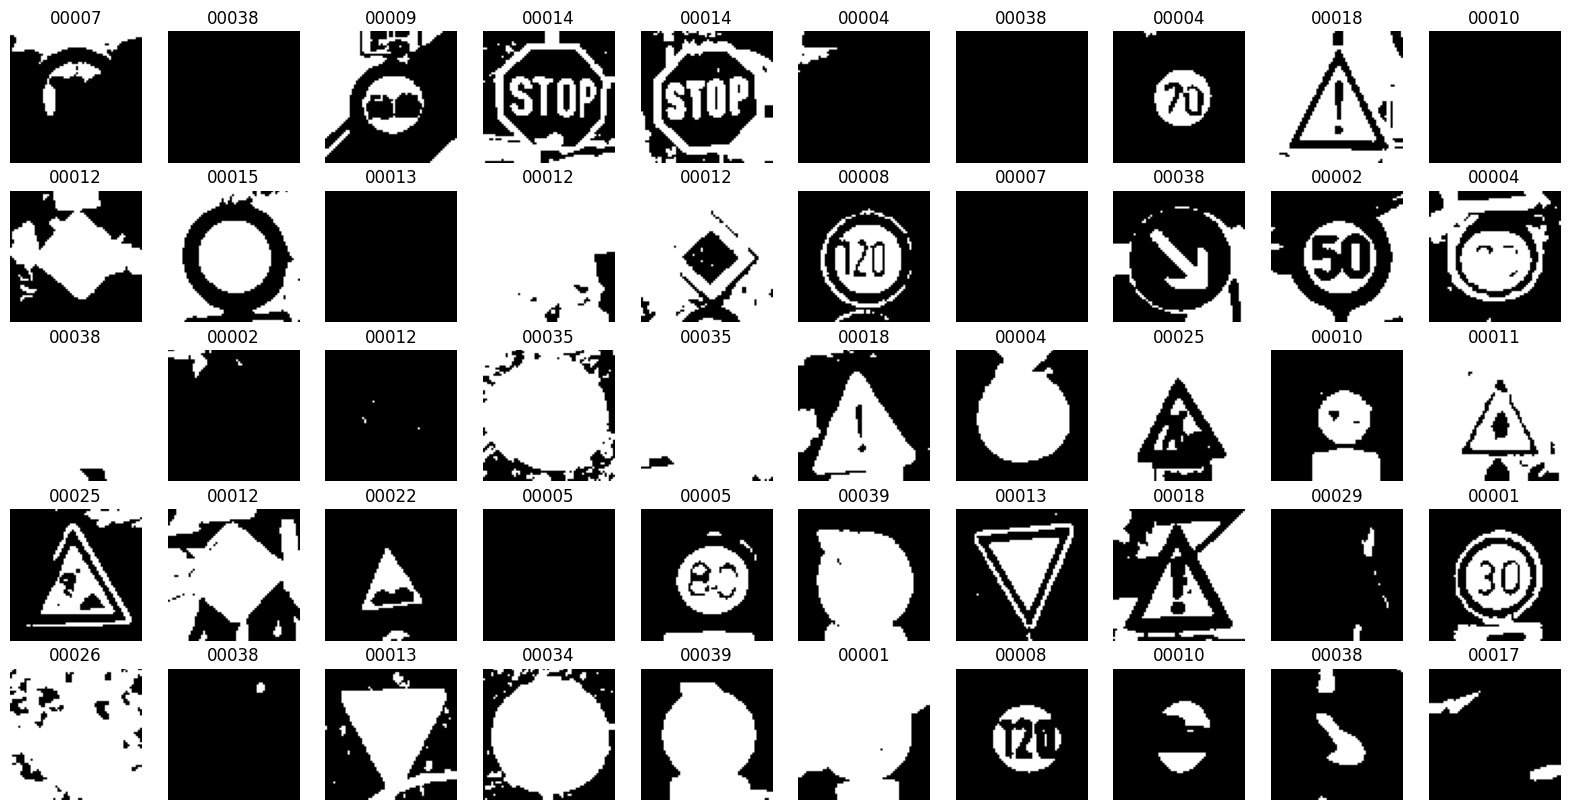

<Figure size 640x480 with 0 Axes>

In [ ]:
# # Supondo que a transformação ThresholdTransform esteja definida corretamente como:
# class ThresholdTransform:
#     def __init__(self, threshold):
#         self.threshold = threshold

#     def __call__(self, img):
#         img = v2.Grayscale()(img)
#         img_bin = torch.where(img > self.threshold, torch.tensor(1.0), torch.tensor(0.0))
#         return img_bin

# threshold_transform = ThresholdTransform(threshold=0.35)

# images_binarized = []
# for image in train_images:
#     image_binarized = threshold_transform(image)
#     images_binarized.append(image_binarized)

# # Converter a lista de imagens binarizadas para um tensor
# images_binarized = torch.stack(images_binarized)

# vcpi_util.show_images(5, 10, images_binarized, train_targets, train_set.classes)

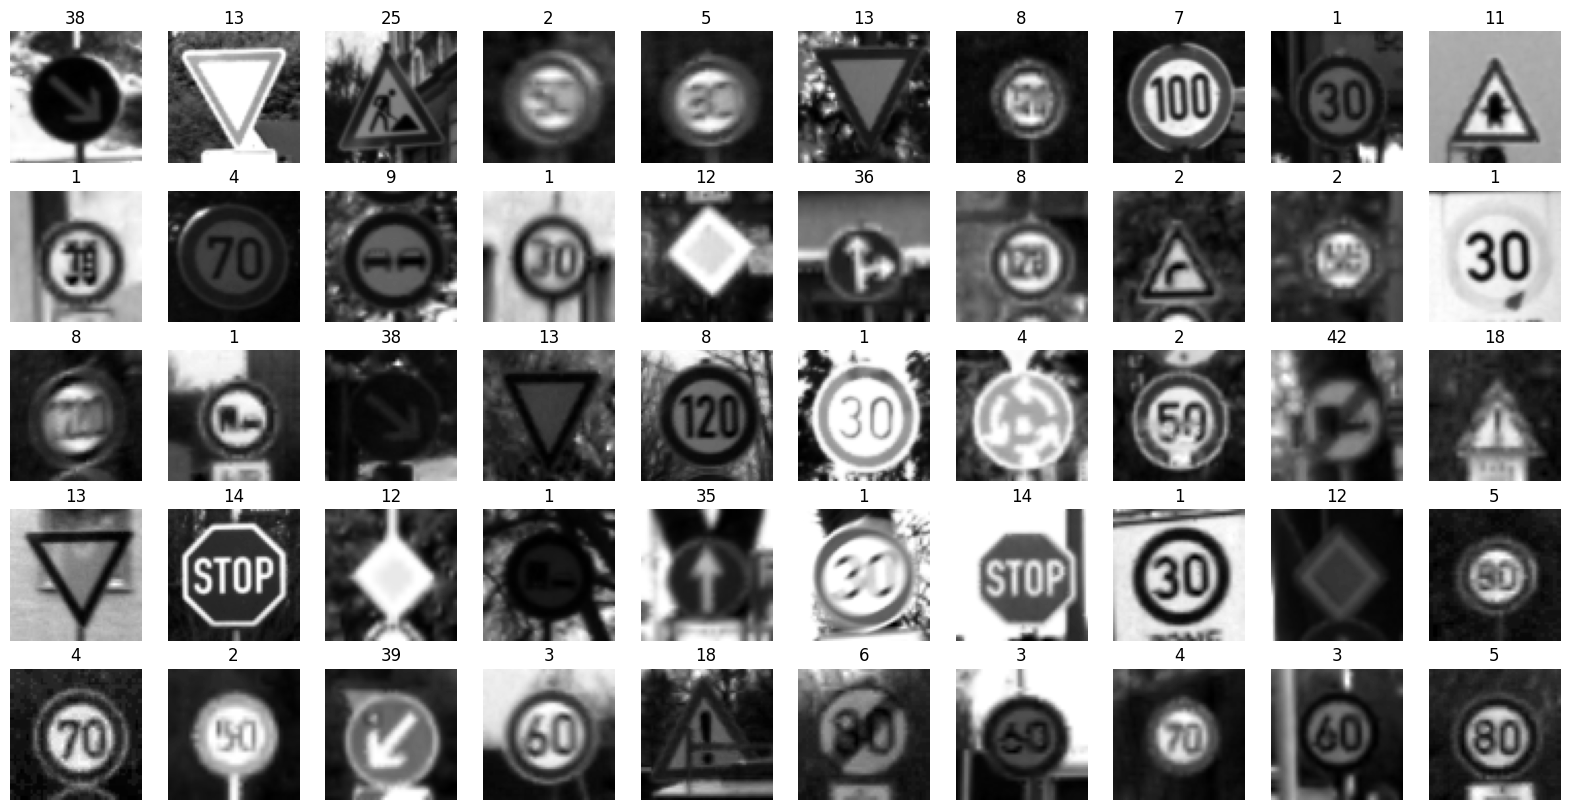

<Figure size 640x480 with 0 Axes>

In [ ]:
# ## testes de transformações, para não estragar o de cima

# transform = v2.Compose([
#     v2.Resize((IMG_SIZE, IMG_SIZE)),
#     v2.RandomAdjustSharpness(0.5),
#     # v2.RandomApply([v2.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2))], p=0.5),
#     # v2.CenterCrop((CROP_HEIGHT, CROP_WIDTH)),  # Add this line for center cropping
#     # v2.RandomCrop((CROP_HEIGHT, CROP_WIDTH)),  # Or use this line for random cropping
#     v2.ToTensor(),
#     v2.Grayscale()

# ])

# train_set = torchvision.datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

# test_set = torchvision.datasets.MNIST(root=TEST_SET_PATH, train=False, download=True, transform=transform)
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# images, targets = next(iter(train_loader))

# new_class_names = ['0' if class_name == '00000' else class_name.replace('0', '') for class_name in train_set.classes]
# train_set.classes = new_class_names

# vcpi_util.show_images(5, 10, images, targets, train_set.classes)

# Auxiliar Functions

In [ ]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0

    for i, (images, targets) in enumerate(data_loader):

        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum
        # value of each row of the input tensor in the given dimension dim;
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()


def train(model, data_loader, epochs, loss_fn, optimizer):

    # sets the model in training mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.train()

    history = {}
    history['accuracy'] = []
    history['loss'] = []

    for epoch in range(epochs):  # loop over the dataset multiple times

        start_time = time.time()
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(data_loader, 0):

            # send data to device, hopefully the GPU
            inputs = inputs.to(device)
            targets = targets.to(device)

            # forward pass, compute the output of the model for the current batch
            outputs = model(inputs)


            _, predicted = torch.max(outputs, 1)

            #compute the loss between the model's outputs and the labels, or targets.
            loss = loss_fn(outputs, targets)

            # zero the parameter gradients
            # this function must be called before calling "backward" on the losses, otherwise the gradients get accumulated with previous batches.
            optimizer.zero_grad()

            # perform backpropagation
            loss.backward()
            #update the model's parameters
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        accuracy = 100 * correct / len(train_set)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Accuracy = {accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['loss'].append(running_loss.cpu().detach().numpy())

    print('Finished Training')

    return(history)




def build_confusion_matrix(model, dataset):

    preds = []
    ground_truth = []

    for images, targets in dataset:

        predictions = model(images.to(device))
        preds_sparse = [np.argmax(x) for x in predictions.cpu().detach().numpy()]
        preds.extend(preds_sparse)
        ground_truth.extend(targets.numpy())

    vcpi_util.show_confusion_matrix(ground_truth, preds, len(dataset.dataset.classes))

# Modelos

Este código prepara e organiza o conjunto das imagens para treinamento e validação, onde são aplicadas transformações de pré-processamento e técnicas de augmentação. São divididos os dados em conjuntos de treino e validação para um treino eficaz e avaliação do desempenho do modelo.

In [ ]:
# Definindo as transformações para normalizar as imagens, convertê-las para tensores e aplicar augmentação
transform_original = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização para ImageNet
])

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),  # Aplica uma chance aleatória de flip horizontal
    transforms.RandomRotation(10),  # Aplica uma rotação aleatória até 10 graus
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalização para ImageNet
])

# Usando a lista de índices filtrados para criar o target_transform
original_dataset = datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform_original)
augmented_dataset = datasets.ImageFolder(root=TRAIN_SET_PATH, transform=transform)

combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Dividindo o conjunto de dados combinado em treino e validação
train_size = int(0.8 * len(augmented_dataset))  # 80% para treinamento
val_size = len(augmented_dataset) - train_size  # 20% para validação
train_dataset, val_dataset = random_split(augmented_dataset, [train_size, val_size])

# Criando os DataLoaders para treinamento e validação
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# For the test set
train_images, train_targets = next(iter(train_loader))
print("Train Set:")
print("Batch shape:", train_images.shape)
img_np = train_images.numpy()
img_np = img_np / 2.64  # Isso assume que seus valores originais variam entre -2.117904 e 2.64
img_np = np.clip(img_np, 0, 1)
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Each image varies between", np.min(img_np), "and", np.max(img_np))
# Putting color channel last so that the image can be displayed
img_np = np.transpose(img_np, (0, 2, 3, 1))
print("Shape after channel transpose:", img_np.shape)
print("Test set samples:", len(train_loader.dataset))
print("Test set batches:", len(train_loader))

Train Set:
Batch shape: torch.Size([32, 3, 64, 64])
Each image varies between 0.0 and 1.0
Shape after channel transpose: (32, 64, 3, 64)
Test set samples: 31380
Test set batches: 981


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

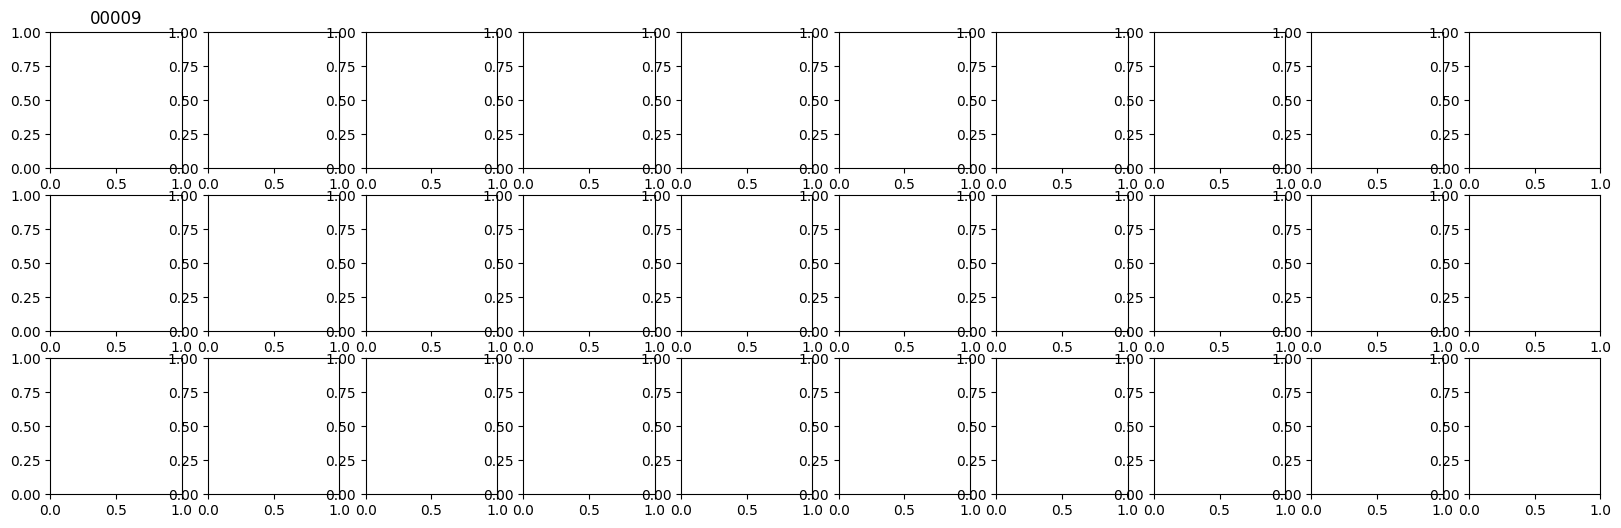

<Figure size 640x480 with 0 Axes>

In [ ]:
train_images, train_targets = next(iter(train_loader))
train_images = np.clip(train_images.numpy(), 0, 1)

vcpi_util.show_images(3,10, train_images, train_targets, augmented_dataset.classes)

## vgg16

De acordo com a documentação oficial do PyTorch, o VGG16 requer um tamanho mínimo de entrada de 32x32 pixels. Embora o VGG16 possa aceitar imagens maiores, como 224x224 pixels, que é o tamanho de entrada padrão para muitos modelos de aprendizado profundo, ele também pode funcionar com imagens menores, como 64x64 pixels. No entanto, o desempenho do modelo pode ser afetado pela diminuição do tamanho da imagem, pois o modelo pode perder informações visuais importantes.

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# Remover a última camada de classificação para ajustar ao seu número de classes
NUM_FEATURES = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]  # Remover a última camada
features.extend([nn.Linear(NUM_FEATURES, NUM_CLASSES)])  # Adicionar a nova camada
vgg16.classifier = nn.Sequential(*features)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
vgg16.to(device)
print(f'device: {device}')

optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

device: cpu


In [ ]:
def train_vgg16_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'accuracy': [], 'loss': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['accuracy'].append(accuracy)
        history['loss'].append(running_loss / len(train_loader))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}')

        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        accuracy_val = 100 * correct_val / total_val
        print(f'Validation Accuracy: {accuracy_val}')

    return history

In [ ]:
history = train_vgg16_model(vgg16, criterion, optimizer, train_loader, val_loader)

final_accuracy = evaluate(vgg16, val_loader)
print(f'Final Validation Accuracy: {final_accuracy}%')

## ResNet

In [ ]:
model = models.resnet50(pretrained=True)

NUM_FEATURES = model.fc.in_features
model.fc = nn.Linear(NUM_FEATURES, NUM_CLASSES)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def train_resnet_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    history = {'accuracy': [], 'loss': []}
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        history['accuracy'].append(accuracy)
        history['loss'].append(running_loss / len(train_loader))

        print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy}')

        # Avaliação no conjunto de validação
        model.eval()
        with torch.no_grad():
            correct_val = 0
            total_val = 0
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        accuracy_val = 100 * correct_val / total_val
        print(f'Validation Accuracy: {accuracy_val}')

    return history

In [ ]:
history = train_resnet_model(model, criterion, optimizer, train_loader, val_loader)

final_accuracy = evaluate(model, val_loader)
print(f'Final Validation Accuracy: {final_accuracy}%')

## CNN com 3 Spatial Transformers

In [ ]:
class SpatialTransformer(nn.Module):
    def __init__(self, size):
        super(SpatialTransformer, self).__init__()
        self.size = size
        self.transformer = nn.Sequential(
            ...

## AlexNet